In [15]:
import matplotlib.pyplot as plt
from argoverse.map_representation.map_api import ArgoverseMap
import numpy as np
import pickle
import zlib
import math
import imageio
import os

am = ArgoverseMap()

# Path to Validation ex_list:
ex_list_path = "../datasets_mini/train/eval.ex_list"

# Path to predictions file. This file is saved after running validation using the model
prediction_path = "../checkpoints/exp0/predictions"

with open(prediction_path, "rb") as f:
    predictions = pickle.load(f)["file2pred"]
    
with open(ex_list_path, "rb") as f:
    ex_list = pickle.load(f)
    
file_names_in_ex_list_order = [int(pickle.loads(zlib.decompress(mapping_i))["file_name"].split("/")[-1][:-4]) for mapping_i in ex_list]
assert len(ex_list) == len(predictions)

In [16]:
def get_map_and_predictions(file_name_int, ex_list, predictions, file_names_in_ex_list_order=None):
    if file_names_in_ex_list_order is not None:
        idx = file_names_in_ex_list_order.index(file_name_int)
        mapping_i = pickle.loads(zlib.decompress(ex_list[idx]))
        return mapping_i, predictions[file_name_int]
    
    else:
        for mapping_i_comp in ex_list:
            mapping_i = pickle.loads(zlib.decompress(mapping_i_comp))
            if int(mapping_i["file_name"].split("/")[-1][:-4]) == file_name_int:
                return mapping_i, predictions[file_name_int]
        assert False, "No scene with given file index"

    
def rotate(x, y, angle):
    res_x = x * math.cos(angle) - y * math.sin(angle)
    res_y = x * math.sin(angle) + y * math.cos(angle)
    return res_x, res_y

def get_lanes(mapping):
    pos_matrix = mapping["pos_matrix"]
    polygons = []
    agent_num = pos_matrix.shape[1]
    
    x = mapping["cent_x"]
    y = mapping["cent_y"]
    city_name = mapping['city_name']
    
    for agent_id in range(agent_num):
        for t_id in range(20):
            pos_x = pos_matrix[t_id, agent_id, 0]
            pos_y = pos_matrix[t_id, agent_id, 1]

            bias_x, bias_y = rotate(pos_x, pos_y, -1*mapping["angle"])
            temp_x, temp_y = (bias_x + x), (bias_y + y)
            
            polygons_i = am.find_local_lane_polygons([temp_x - 100, temp_x + 100, temp_y - 100, temp_y + 100], city_name)
            
            for polygon_i in polygons_i:
                # check if polygon is available
                available = False
                for available_polygone in polygons:
                    if np.all(available_polygone == polygon_i[:, :2]):
                        available = True
                        break
                        
                if available:
                    continue

                polygons.append(polygon_i[:, :2])

        break
           

    polygons = [polygon.copy() for polygon in polygons]
    angle = mapping['angle']
    for index_polygon, polygon in enumerate(polygons):
        for i, point in enumerate(polygon):
            point[0], point[1] = rotate(point[0] - x, point[1] - y, angle)

    polygons = [polygon for polygon in polygons]
    
    return polygons



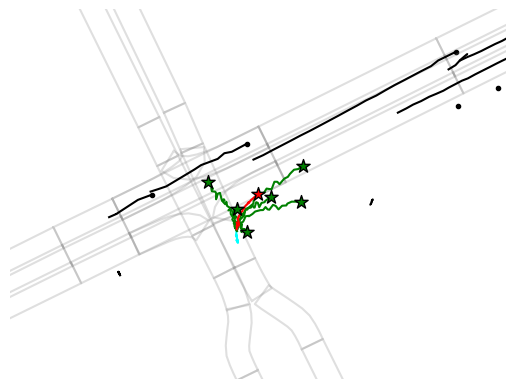

In [23]:
import os
def plot_scene(file_name_int):
    mapping_i, predictions_i = get_map_and_predictions(file_name_int, ex_list, predictions, file_names_in_ex_list_order)
    mapping_i = mapping_i.copy()
    predictions_i = predictions_i.copy()
    
    lanes = get_lanes(mapping_i)
    # === Plot Lanes ===
    for lane in lanes:
        plt.plot(lane[:, 0], lane[:, 1], c="gray", alpha=0.25)
        
    pos_matrix = mapping_i["pos_matrix"]
    
    # === Plot Ego Past ===
    plt.plot(pos_matrix[:20, 0, 0], pos_matrix[:20, 0, 1], c="cyan")
    
    # === Plot Other Agents Past ===
    agent_num = pos_matrix.shape[1] - 1
    for j in range(agent_num):
        positions = pos_matrix[:20, j + 1]
        plt.plot(positions[:, 0], positions[:, 1], c="black")
        plt.scatter(positions[-1, 0], positions[-1, 1], marker=".", c="black")
        
    
    # === Plot Ego Futures ===
    angle = mapping_i["angle"]
    x = mapping_i["cent_x"]
    y = mapping_i["cent_y"]
    for pred_i_j in predictions_i:
        
        # To local coordinate system 
        for i, point in enumerate(pred_i_j):
            point[0], point[1] = rotate(point[0] - x, point[1] - y, angle)
            
        plt.plot(pred_i_j[:, 0], pred_i_j[:, 1], c="green")
        plt.scatter(pred_i_j[-1, 0], pred_i_j[-1, 1], marker="*", c="green", edgecolors="black", s=100, zorder=5)
        
    # === Plot Ego Future (GT) ===
    gt = mapping_i["origin_labels"]
    for i, point in enumerate(gt):
        point[0], point[1] = rotate(point[0] - x, point[1] - y, angle)
    
    plt.plot(gt[:, 0], gt[:, 1], c="red")
    plt.scatter(gt[-1, 0], gt[-1, 1], marker="*", c="red", edgecolors="black", s=100, zorder=6)
    
    origin_x, origin_y = gt[-1]
    plt.axis('equal')
    
    plt.xlim([origin_x - 30, origin_x + 30])
    plt.ylim([origin_y - 30, origin_y + 30])
    plt.axis('off')
    
    plt.show()
    

file_name_int = 4210
plot_scene(file_name_int)

In [10]:
# code snippets to create gifs are from tutorial https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30

def save_gif(file_name_int, gif_save_path="predictions.gif"):
    
    mapping_i, predictions_i = get_map_and_predictions(file_name_int, ex_list, predictions, file_names_in_ex_list_order)
    mapping_i = mapping_i.copy()
    predictions_i = predictions_i.copy()
    
    
    pos_matrix = mapping_i["pos_matrix"]
    angle = mapping_i["angle"]
    x = mapping_i["cent_x"]
    y = mapping_i["cent_y"]
        
    lanes = get_lanes(mapping_i)
    
    # To local coordinate system 
    for pred_i_j in predictions_i:
        for i, point in enumerate(pred_i_j):
            point[0], point[1] = rotate(point[0] - x, point[1] - y, angle)
            
    gt = mapping_i["origin_labels"]
    for i, point in enumerate(gt):
        point[0], point[1] = rotate(point[0] - x, point[1] - y, angle)
    
    
    filenames = []
    
    for t in range(30):
        filename = f"{t}.png"
        filenames.append(filename)
        
        for lane in lanes:
            plt.plot(lane[:, 0], lane[:, 1], c="gray", alpha=0.25)
        
        # === Plot Ego Past ===
        plt.plot(pos_matrix[:20, 0, 0], pos_matrix[:20, 0, 1], c="cyan")
        
        # === Plot Other Agents up to t ===
        agent_num = pos_matrix.shape[1] - 1
        for j in range(agent_num):
            positions = pos_matrix[:20 + t, j + 1]
            plt.plot(positions[:, 0], positions[:, 1], c="black")
            plt.scatter(positions[-1, 0], positions[-1, 1], marker=".", c="black")
            
            
        # === Plot Ego Futures up to t===
        for pred_i_j in predictions_i:
            plt.plot(pred_i_j[:t, 0], pred_i_j[:t, 1], c="green")
            plt.scatter(pred_i_j[t, 0], pred_i_j[t, 1], marker="*", c="green", edgecolors="black", s=100, zorder=5)

        # === Plot Ego Future (GT) ===
        
        plt.plot(gt[:t, 0], gt[:t, 1], c="red")
        plt.scatter(gt[t, 0], gt[t, 1], marker="*", c="red", edgecolors="black", s=100, zorder=6)

        origin_x, origin_y = gt[t]
        plt.axis('equal')

        plt.xlim([origin_x - 30, origin_x + 30])
        plt.ylim([origin_y - 30, origin_y + 30])
        plt.axis('off')

        plt.savefig(filename)
        plt.close()
        
    
    with imageio.get_writer(gif_save_path, mode="I") as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        
    for filename in set(filenames):
        os.remove(filename)
    
    
file_name_int = 666
save_gif(file_name_int)

/tmp/ipykernel_191147/467345481.py:70: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
